Consider the piezo-electric coupled equations

$$
T = c^E \frac{\partial u}{\partial x} + e \frac{\partial \phi}{\partial x} \\
D = e \frac{\partial u}{\partial x} - \epsilon^S \frac{\partial \phi}{\partial x}
$$

We can combine this with the equation of motion

$$
\frac{\partial T}{\partial x} = \rho \frac{\partial^2 u}{\partial t^2}
$$

and the zero gradient of the electric displacement
$$
\frac{\partial D}{\partial x} = 0
$$

to obtain 
$$ \label{eq:inhom_piezo_stat}
\frac{\partial}{\partial x}(c^E \frac{\partial u}{\partial x}) + \frac{\partial}{\partial x} (e \frac{\partial \phi}{\partial x}) = \rho \frac{\partial^2 u}{\partial t^2} = -\rho \omega^2 u \\
\frac{\partial}{\partial x}(e \frac{\partial u}{\partial x}) - \frac{\partial}{\partial x}(\epsilon^S \frac{\partial \phi}{\partial x}) = 0
$$

We can use the 1D FD system matrix derived for equations of the form 

$$
\frac{\partial}{\partial x}\left(k \frac{\partial y}{\partial x}\right) = M \mathbf{y},
$$
where M is a symmetric matrix.

To make convert equation \eqref{eq:inhom_piezo_stat} to 

$$
A \mathbf{u} + B \pmb{\phi} = \omega^2 (-\pmb{\rho} \circ I) \mathbf{u}\\
C \mathbf{u} - D \pmb{\phi} = \mathbf{0}
$$

And write 

$$
\mathbf{X} = (\mathbf{u}, \pmb{\phi})^T
$$

Such that we can write 

$$
\begin{bmatrix}
A & B\\
C & -D
\end{bmatrix}
\mathbf{X}
= 
\omega^2
\begin{bmatrix}
(-\pmb{\rho} \circ I) & \mathbf{0}\\
\mathbf{0} & \mathbf{0}
\end{bmatrix}
\mathbf{X}
$$

which is the generalized eigenvalue problem we need to solve.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [109]:
#Function that returns one of the matrices made according to equations above
def spacedep_matrix(coeff, dx, neumann = True):
    #create the new coefficient a
    a = (coeff[1:] + coeff[:-1]) / 2
    
    #main diagonal
    main = - (a[:-1] + a[1:]) 
    
    #off diagonal
    off = a[1:-1]
    
    #If we have a neumann boundary condition we get different values at the beginning and end points
    if neumann == True:
        main[0] = -a[1]; main[-1] = -a[-2]
    
    #construct the matrix
    M = 1 / dx**2 * (np.diag(main, k=0) + np.diag(off,k=1) + np.diag(off,k=-1))  
    
    return M 

# Testing matrices and linear algebra by hand

Use a 5 point grid, Dirichlet on both fields for now. 

In [132]:
N = 5
rho = e = eps = c = np.ones(N)
dx = 1

A = spacedep_matrix(c, dx, neumann = False)
B = spacedep_matrix(e, dx, neumann = False)
C = spacedep_matrix(e, dx, neumann = False)
D = spacedep_matrix(eps, dx, neumann = False)
LHS = np.block([
    [A , B],
    [C, -D]
])
RHS = np.block([
    [-np.diag(rho[1:-1]), np.zeros((N-2,N-2))],
    [np.zeros((N-2, N-2)), np.zeros((N-2,N-2))]
])

In [133]:
print(A)
print(B)
print(C)
print(D)
print(LHS)
print(RHS)

[[-2.  1.  0.]
 [ 1. -2.  1.]
 [ 0.  1. -2.]]
[[-2.  1.  0.]
 [ 1. -2.  1.]
 [ 0.  1. -2.]]
[[-2.  1.  0.]
 [ 1. -2.  1.]
 [ 0.  1. -2.]]
[[-2.  1.  0.]
 [ 1. -2.  1.]
 [ 0.  1. -2.]]
[[-2.  1.  0. -2.  1.  0.]
 [ 1. -2.  1.  1. -2.  1.]
 [ 0.  1. -2.  0.  1. -2.]
 [-2.  1.  0.  2. -1. -0.]
 [ 1. -2.  1. -1.  2. -1.]
 [ 0.  1. -2. -0. -1.  2.]]
[[-1. -0. -0.  0.  0.  0.]
 [-0. -1. -0.  0.  0.  0.]
 [-0. -0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


Start with just what we expect for acoustic case on it's own. 

This should give the same answer as the full code of the generalised problem. 

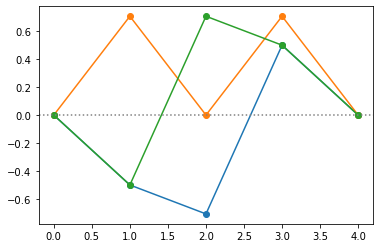

In [134]:
eigval, eigvec = np.linalg.eig(-A)
for i in range(3):
    x = np.zeros(5)
    x[1:4] = eigvec[i]
    plt.plot(x, 'o-')
plt.axhline(0, ls=":", c='grey')

This is indeed what we expect: modes are waves, there are 3 of them. Blue is the lowest "fundamental mode" of a string, orange is the second harmonic, and the green is the third harmonic. 

Now, let's try the generalised problem and see what we get. 

In [80]:
eigval

array([-3.41421356, -2.        , -0.58578644])

In [75]:
vals, vecs = la.eig(LHS,RHS)

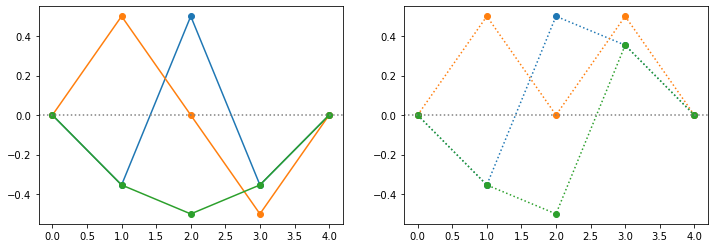

In [76]:
plt.subplots(figsize=(12,4))
plt.subplot(121)
for i in range(3):
    x = np.zeros(5)
    x[1:4] = vecs[i][0:3]
    plt.plot(x, 'o-')
plt.axhline(0, ls=":", c='grey')
plt.subplot(122)
for i in range(3):
    x = np.zeros(5)
    x[1:4] = vecs[i][0:3]
    x[3] = -x[3]
    plt.plot(x, 'o:')
plt.axhline(0, ls=":", c='grey')

OK, this does not look like what we expect. 

In fact, it looks like we are missing a minus sign on the right half? 

<font color=red>UPDATE: it was the minus sign in the rho!!!! Changing it makes everything work. The ordering is inverted, but that is probably OK.</font>

Let's test it with an even number of points? 

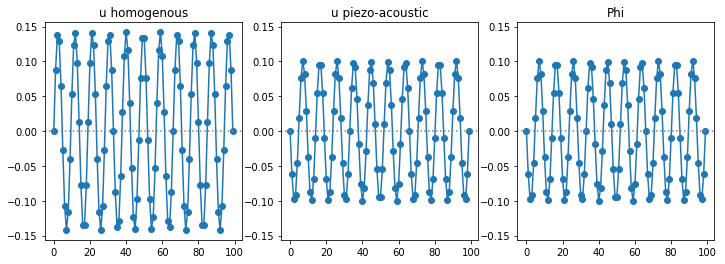

/Users/samkatiraee-far/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


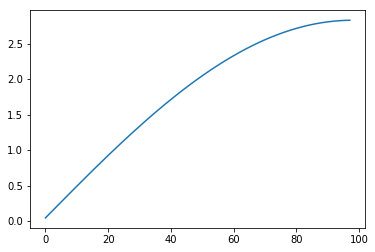

In [27]:
N = 100
rho = e = eps = c = np.ones(N)
dx = 1

#e = e/5

A = spacedep_matrix(c, dx, neumann = False)
B = spacedep_matrix(e, dx, neumann = False)
C = spacedep_matrix(e, dx, neumann = False)
D = spacedep_matrix(eps, dx, neumann = False)
LHS = np.block([
    [A , B],
    [C, -D]
])
RHS = np.block([
    [-np.diag(rho[1:-1]), np.zeros((N-2,N-2))],
    [np.zeros((N-2, N-2)), np.zeros((N-2,N-2))]
])

plt.figure(figsize=(12,4))

num = 20


plt.subplot(131)
vals, vecs = np.linalg.eig(-A)
vecs = vecs[:,np.argsort(vals)]
for i in range(num,num+1):
    x = np.zeros(N)
    x[1:(N-1)] = vecs[:,i]
    plt.plot(x, 'o-')
plt.axhline(0, ls=":", c='grey')
plt.title("u homogenous")
ylim = plt.ylim()

plt.subplot(132)
vals, vecs = la.eig(LHS,RHS)
vecs = vecs[:,np.argsort(vals)]
for i in range(num,num+1):
    x = np.zeros(N)
    x[1:N-1] = vecs[0:N-2,i]
    plt.plot(x, 'o-')
plt.axhline(0, ls=":", c='grey')
plt.title("u piezo-acoustic")
plt.ylim(ylim)

plt.subplot(133)
vals, vecs = la.eig(LHS,RHS)
vecs = vecs[:,np.argsort(vals)]
for i in range(num,num+1):
    x = np.zeros(N)
    x[1:N-1] = vecs[N-2:,i]
    plt.plot(x, 'o-')
plt.axhline(0, ls=":", c='grey')
plt.title("Phi")
plt.ylim(ylim)
plt.show()

plt.plot(np.sqrt(np.sort(vals)))

[[-200000.  100000.       0. ...       0.       0.       0.]
 [ 100000. -200000.  100000. ...       0.       0.       0.]
 [      0.  100000. -200000. ...       0.       0.       0.]
 ...
 [      0.       0.       0. ... -200000.  100000.       0.]
 [      0.       0.       0. ...  100000. -200000.  100000.]
 [      0.       0.       0. ...       0.  100000. -200000.]] [[-2.e-05  1.e-05  0.e+00 ...  0.e+00  0.e+00  0.e+00]
 [ 1.e-05 -2.e-05  1.e-05 ...  0.e+00  0.e+00  0.e+00]
 [ 0.e+00  1.e-05 -2.e-05 ...  0.e+00  0.e+00  0.e+00]
 ...
 [ 0.e+00  0.e+00  0.e+00 ...  0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00 ...  0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00 ...  0.e+00  0.e+00  0.e+00]] [[-200000.  100000.       0. ...       0.       0.       0.]
 [ 100000. -200000.  100000. ...       0.       0.       0.]
 [      0.  100000. -200000. ...       0.       0.       0.]
 ...
 [      0.       0.       0. ...       0.       0.       0.]
 [      0.       0.       0. ...       0.  

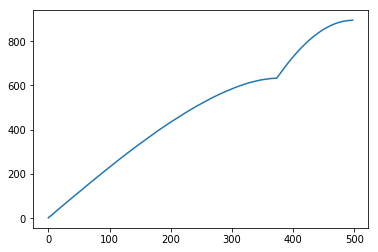

In [141]:
N = 500
rho = np.ones(N)
e = np.ones(N)
c = np.ones(N)
eps = np.ones(N)
dx = 1

e[N//2:] = 0

A = spacedep_matrix(c, dx, neumann = False)
B = spacedep_matrix(e, dx, neumann = False) # phi
C = spacedep_matrix(e, dx, neumann = False)
D = spacedep_matrix(eps, dx, neumann = False)


normu = 1e-5
normphi = 1e5

A/= normu
B/= normphi
C/= normu
D/= normphi

print(A,B,C,D)


normu = normphi = 1



LHS = np.block([
    [A , B],
    [C, -D]
])
RHS = np.block([
    [-np.diag(rho[1:-1]), np.zeros((N-2,N-2))],
    [np.zeros((N-2, N-2)), np.zeros((N-2,N-2))]
])

plt.figure(figsize=(12,4))

n1 = 10
n2 = n1+1

plt.subplot(131)
vals, vecs = np.linalg.eig(-A)
vecs = vecs[:,np.argsort(vals)]
for i in range(n1,n2):
    x = np.zeros(N)
    x[1:(N-1)] = vecs[:,i]
    plt.plot(x, '-')
plt.axhline(0, ls=":", c='grey')
plt.title("u homogenous")
#ylim = plt.ylim()

plt.subplot(132)
vals, vecs = la.eig(LHS,RHS)
vecs = vecs[:,np.argsort(vals)]
for i in range(n1,n2):
    x = np.zeros(N)
    x[1:N-1] = vecs[0:N-2,i]
    plt.plot(x, '-')
plt.axhline(0, ls=":", c='grey')
plt.title("u piezo-acoustic")
#plt.ylim(ylim)

plt.subplot(133)
for i in range(n1,n2):
    x = np.zeros(N)
    x[1:N-1] = vecs[N-2:,i]
    plt.plot(x, '-')
plt.axhline(0, ls=":", c='grey')
plt.title("Phi")
#plt.ylim(ylim)
plt.show()

plt.plot(np.sqrt(np.sort(vals.real)))
plt.show()

To do: 

* Mention that this fails if we put parameters in blindly because of numerical issues
    * Plots / subssection in report
* Show that these problems are fixed if we scale u and phi appropriately
    * Also in report

before
Max value of A =  790000000000.0
Max value of B =  20.0
Max value of C =  20.0
Max value of D =  1.8593799000000001397e-10
after
Max value of A =  790000000.0000000165
Max value of B =  20000000.0
Max value of C =  0.020000000000000000416
Max value of D =  0.00018593799000000001398


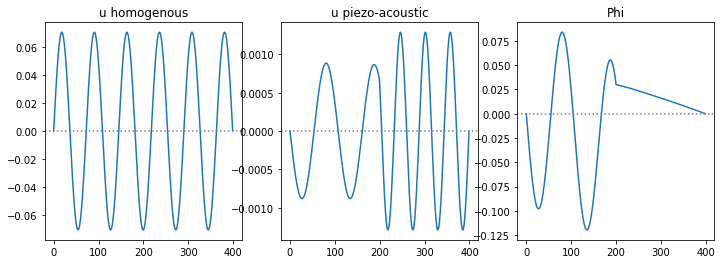

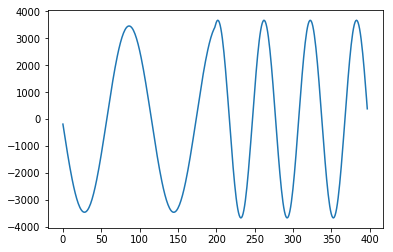

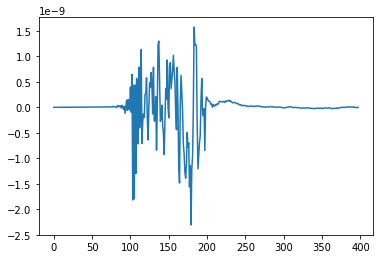

In [219]:
#create discretized position array
x0 = 0
x1 = 500e-6
N = 400
x = np.linspace(x0,x1,N)
x = np.arange(0,N)
dx = x[1] - x[0]
dx = 1

#material property arrays
eps0 = 8.85419e-12         #permitivitty of free space (F/m)
eps_r = np.ones(N, dtype=np.float128) * 10.5  #relative permitivitty [-]
eps = eps0 * eps_r         #permitivitty (F/m)
rho = np.ones(N, dtype=np.float128) * 3260    #density [kg/m^3]
e = 10 * np.ones(N, dtype=np.float128)         #C/m^{-2}
c = np.ones(N,dtype=np.float128) * 395e9     #[pa]

e[N//2:] = 0


A = spacedep_matrix(c, dx, neumann = False); 
B = spacedep_matrix(e, dx, neumann = False); 
C = spacedep_matrix(e, dx, neumann = False); 
D = spacedep_matrix(eps, dx, neumann = False);

umax = np.max(A)
phimax = np.max(D) 

print("before")
print("Max value of A = ",np.max(np.abs(A)))
print("Max value of B = ",np.max(np.abs(B))) 
print("Max value of C = ",np.max(np.abs(C))) 
print("Max value of D = ",np.max(np.abs(D)))  


unorm = 1e-3
phinorm = 1e6


A*= unorm
B*= phinorm
C*= unorm
D*= phinorm

print("after")
print("Max value of A = ",np.max(np.abs(A)))
print("Max value of B = ",np.max(np.abs(B))) 
print("Max value of C = ",np.max(np.abs(C))) 
print("Max value of D = ",np.max(np.abs(D))) 


LHS = np.block([
    [A , B],
    [C, -D]
])
RHS = np.block([
    [-np.diag(rho[1:-1]), np.zeros((N-2,N-2))],
    [np.zeros((N-2, N-2)), np.zeros((N-2,N-2))]
])

plt.figure(figsize=(12,4))

n1 = 10
n2 = n1+1

plt.subplot(131)
vals, vecs = la.eig(-A)
vecs = vecs[:,np.argsort(vals)]
for i in range(n1,n2):
    x = np.zeros(N)
    x[1:(N-1)] = vecs[:,i]
    plt.plot(x, '-')
plt.axhline(0, ls=":", c='grey')
plt.title("u homogenous")
#ylim = plt.ylim()

plt.subplot(132)
vals, vecs = la.eig(LHS,RHS)
vecs = vecs[:,np.argsort(vals)]
for i in range(n1,n2):
    x = np.zeros(N)
    x[1:N-1] = vecs[0:N-2,i]  
    plt.plot(x, '-')
plt.axhline(0, ls=":", c='grey')
plt.title("u piezo-acoustic")
#plt.ylim(ylim)

plt.subplot(133)
for i in range(n1,n2):
    x = np.zeros(N)
    x[1:N-1] = vecs[N-2:,i]
    plt.plot(x, '-')
plt.axhline(0, ls=":", c='grey')
plt.title("Phi")
#plt.ylim(ylim)
plt.show()

plt.plot(np.sqrt(np.sort(vals.real)))
plt.show()



ind = 9
check1 = LHS.dot(vecs)
check2 = vals[ind] * RHS.dot(vecs)

plt.plot(check1[:,ind][:N-2])
plt.show()
plt.plot(check1[:,ind][N-2:])
plt.show()

In [82]:
vals[0:3]

array([6.82842712+0.j, 4.        +0.j, 1.17157288+0.j])

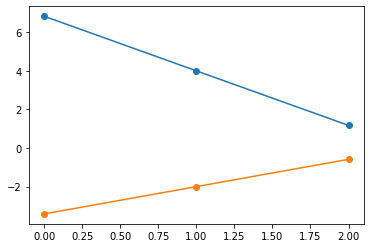

In [85]:
plt.plot(np.real(vals[0:3]), 'o-')
plt.plot(np.real(eigval[0:3]), 'o-')

In [18]:
def piezo_inhomogeneous(x, rho, c, e, eps):
#     BC_check = ["neumann", "dirichlet"]
#     assert ((BC1 in BC_check) and (BC2 in BC_check)), "both boundary conditions must be 'neumann' or 'dirichlet'"
    
    #now slice off the end points because they are not in the statevector
    rho = rho[1:-1]
    
    #Number of points
    N = len(x)
    
    #create the needed matrices
    A = spacedep_matrix(c, dx, neumann = False) # Acoustic (u)
    B = spacedep_matrix(e, dx, neumann = False) # Cross term, operating on phi
    C = spacedep_matrix(e, dx, neumann = False) # Cross term, operating on u
    D = spacedep_matrix(eps, dx, neumann = False) # Potential (phi)
    
    #Now create the LHS and RHS matrices 
    LHS = np.block([
        [A , B],
        [C, -D]
    ])
    #LHS += LHS.T; LHS/= 2

    RHS = np.block([
        [np.diag(-rho)        , np.zeros((N-2,N-2))],
        [np.zeros((N-2, N-2)), np.zeros((N-2,N-2))]
    ])

    #now solve the generalized eigenvalue problem
    vals, vecs = la.eig(LHS,RHS)
    
    #sort the vectors and values
    vecs_sort = vecs[:,np.argsort(vals)]
    freq_sort = np.sqrt(np.sort(vals))
    
    return freq_sort, vecs_sort

In [182]:
#create discretized position array
x0 = 0
x1 = 500e-6
N = 500
x = np.linspace(x0,x1,N)
x = np.arange(0,N)
dx = x[1] - x[0]

#material property arrays
eps0 = 8.85419e-12         #permitivitty of free space (F/m)
eps_r = np.ones(N) * 1#10.5  #relative permitivitty [-]
eps = eps0 * eps_r         #permitivitty (F/m)
rho = np.ones(N) * 1#3260    #density [kg/m^3]
e = 1 * np.ones(N)         #C/m^{-2}
c = np.ones(N) * 1#395e9     #[pa]

# #find index where x>start_bulk
# start_bulk = 250e-6
# bulk_i = np.where(x>start_bulk)
e[N//2:] = 0



#INHOMOGENEOUS For those indices set bulk properties 
# eps_r[bulk_i] = 10.5
# e[bulk_i] = 0
# eps = eps_r * eps0
#c[bulk_i] = 395e9 * 10
# rho[bulk_i] = 3260 #* 10


    

N = 500
rho = np.ones(N)
e = 5 * np.ones(N)
c = np.ones(N)
eps = np.ones(N)
x = np.arange(0,N)
x[1] - x[0]

e[N//2:] = 0
# rho[N//2:] = 3
# c[N//2:] = 8
# eps[N//2:] = 0.5



#now solve the generalized eigenvalue problem
freqs, vecs = piezo_inhomogeneous(x, rho, c, e, eps)

u = vecs[:len(vecs)//2]
phi = vecs[len(vecs)//2:]

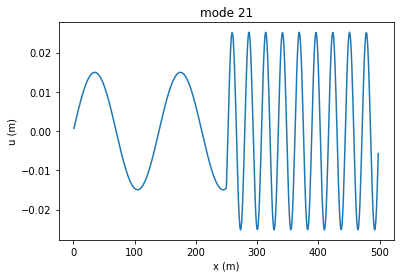

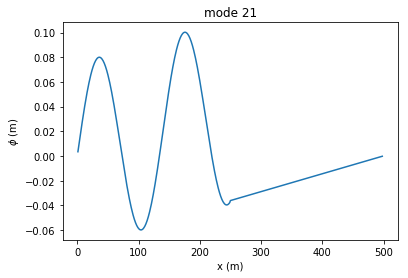

In [183]:
mode_ind = 21

#plot eigenfrequencies
plt.plot(freqs.real)
plt.xlabel("n")
plt.ylabel("$\omega_n$ (rad)")
plt.plot(mode_ind,freqs[mode_ind-1].real, 'o')
plt.show()


plt.plot(x[1:-1], u[:,mode_ind].real)
plt.title(f"mode {mode_ind}")
# plt.plot(x[1:-1], u[:,mode_ind].real - u[:,mode_ind].imag)
plt.xlabel("x (m)")
plt.ylabel("u (m)")
plt.show()


plt.show()
plt.title(f"mode {mode_ind}")
plt.plot(x[1:-1], phi[:,mode_ind].real)
# plt.plot(x[1:-1], phi[:,mode_ind].imag - phi[:,mode_ind].real)
plt.xlabel("x (m)")
plt.ylabel("$\phi$ (m)")
plt.show()

In [197]:
a = np.diag(np.ones(20, dtype=np.float128))
print(a.dtype)


float128


dtype('complex128')